In [45]:
import requests
import pandas as pd

In [133]:
def get_fund_div_data(symbol):
    
    url = 'https://stock.finance.sina.com.cn/fundInfo/api/openapi.php/FundPageInfoService.tabfh'

    data_input = {
        'symbol' : symbol, 
        'format' : 'json',
    }

    resp = requests.get(url, params=data_input)
    data = resp.json()
    div = pd.DataFrame(data['result']['data']['fhdata']).astype({'mffh':float})
    
    div = div[div['mffh'] > 0.0]
    
    div = div.drop('fhr', axis=1)

    RENAME = {
        'djr' : 'date',
        'mffh' : 'amount',
    }

    div = div.rename(columns = RENAME)

    div['date'] = pd.to_datetime(div['date'])
   
    # sort div data frame from old to new
    div = div.set_index('date').sort_index()
    
    return div

In [134]:
div = get_fund_div_data('020005')

In [135]:
div

,amount
date,
2006-03-10,0.0300
2006-09-01,0.1000
2018-01-16,0.1146
2018-06-20,0.0550
2020-01-13,0.1310
2021-01-18,0.2680


In [11]:
from arctic import Arctic, CHUNK_STORE
lib = Arctic('localhost')
fund = lib.get_library('fund')

/home/azureuser/miniconda3/envs/fundopt/lib/python3.9/site-packages/arctic-1.80.0-py3.9.egg/arctic/store/_pandas_ndarray_store.py:8: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


In [83]:
df = fund.read('020005')

In [13]:
import datetime

In [69]:
div_date = datetime.date(2021, 1, 18)

In [70]:
df.loc[div_date:, 'NAV'] += 0.268

In [73]:
diff = df.diff()

<AxesSubplot:xlabel='NAV', ylabel='ACC_NAV'>

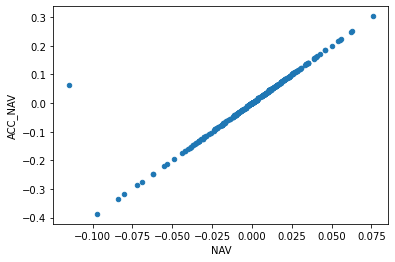

In [74]:
diff.plot.scatter('NAV', 'ACC_NAV')

In [78]:
df.NAV.pct_change(freq='20B')

date
2020-01-07         NaN
2020-01-08         NaN
2020-01-09         NaN
2020-01-10         NaN
2020-01-13         NaN
                ...   
2021-05-03   -0.016602
2021-05-04   -0.006152
2021-05-05    0.013691
2021-05-06   -0.011885
2021-05-07   -0.006344
Name: NAV, Length: 349, dtype: float64

In [99]:
def calc_return_ts(nav, div, start, end, offset):
    div = div.loc[start:end]
    nav = nav.loc[start:end]
    for ex_date, row in div.itertuples(index=True):
        nav.loc[ex_date:] += row.amount
        
    start_nav = nav.shift(offset)
    end_nav = nav
    
    ret = (end_nav/start_nav) - 1
    
    return ret, nav

In [96]:
start = datetime.date(2020, 1, 1)
end = datetime.date(2021, 5, 7)

In [100]:
ret_df, nav = calc_return_ts(df['NAV'], div, start, end, 20)

In [98]:
ret_df.loc[div_date:]

date
2021-01-18   -0.048435
2021-01-19   -0.069027
2021-01-20   -0.071303
2021-01-21   -0.039930
2021-01-22   -0.042467
                ...   
2021-05-03   -0.019493
2021-05-04   -0.007237
2021-05-05    0.016162
2021-05-06   -0.014009
2021-05-07   -0.007503
Name: NAV, Length: 80, dtype: float64

In [127]:
nav.loc[div_date:]

date
2021-01-18    2.010
2021-01-19    1.977
2021-01-20    1.988
2021-01-21    2.034
2021-01-22    2.045
              ...  
2021-05-03    1.908
2021-05-04    1.908
2021-05-05    1.908
2021-05-06    1.877
2021-05-07    1.854
Name: NAV, Length: 80, dtype: float64

In [87]:
ret_df.tail()

date
2021-05-03   -0.019493
2021-05-04   -0.007237
2021-05-05    0.016162
2021-05-06   -0.014009
2021-05-07   -0.007503
Name: NAV, dtype: float64

In [88]:
df.loc[div_date:]

,NAV,ACC_NAV
date,,
2021-01-18,1.611,8.825
2021-01-19,1.578,8.693
2021-01-20,1.589,8.737
2021-01-21,1.635,8.921
2021-01-22,1.646,8.964
...,...,...
2021-05-03,1.509,8.418
2021-05-04,1.509,8.418
2021-05-05,1.509,8.418


In [121]:
div = div.loc[start:end]
nav = nav.loc[start:end]
for row in div.itertuples(index=True):
    nav.loc[row.Index:] += row.amount

In [122]:
div

,payDate,amount
exDate,,
2020-01-13,2020-01-14,0.131
2021-01-18,2021-01-19,0.268


In [128]:
start_nav = nav.shift(20)
end_nav = nav

ret = (end_nav/start_nav) - 1

In [129]:
ret.loc[div_date:]

date
2021-01-18    0.101974
2021-01-19    0.082694
2021-01-20    0.079262
2021-01-21    0.109051
2021-01-22    0.105405
                ...   
2021-05-03   -0.015480
2021-05-04   -0.005732
2021-05-05    0.012739
2021-05-06   -0.011064
2021-05-07   -0.005898
Name: NAV, Length: 80, dtype: float64